## Roadmap for Phase 3 Project: DS-Live-022023

1. **Classification project → Categorical target**
    - Explore target, how many classes (binary or multiclass)?
    - Is there a class imbalance? If so might need to consider certain techniques
        - Either SMOTE or class_weight maybe
    - Determine the business context/problem for stakeholder
        - How is your model helping to address/solve the problem?
    - Will you want some form of inference (will affect model choices)
        - Can be very beneficial
    - Determine which evaulation metric/metrics are most important
        - THIS IS BIG
        - Think in terms of cost matrix, fp vs fn etc…


2. **EDA → Explore your dataset and features**
    - Basic summary info, .describe, null or missing values, column types
    - What features are relevant for your model/analysis and why? 
    - Relationships with target
    - Exploratory visuals, correlations, pairplots, heatmaps, histograms etc…
    - Determine how you will handle null values
        - Impute values, drop rows or columns etc…
        - Take a look at the different types of imputers (KNNI is powerful but slow)
    - Determine how you will handle categorical variables
        - Binary?
        - Ordinal or One-Hot encode?
    - Will you need to scale the numeric data?


3. **Determine an appropriate validation procedure**
    - Highly recommended to cross_validate with a pipeline (best way)
    - train_test_split your data


4. **Develop ColumnTransformer → data preprocessing pipeline based on EDA above**
    - Sub-pipes for numeric and categorical columns
        - As many as you need if treating some columns differently
        - Keep in mind things like handle_unknown = ‘ignore’
    - Create one pipeline with numeric scaling, another without if needed
    - Test your column transformer
        - Fit_transform train data
        - Transform test data
        - Should have the same number of columns after transformation


5. **Modelling Process → Pipeline using ColumnTransformer and model algorithm**
    - Start with a DummyClassifier
        - Evaluate based on chosen metric/metrics → need to beat this
    - Create and evaluate first simple model: Simple → Complex
        - Start with defaults, logistic regression or decision tree based on your data
        - Could try other algorithms if you think warranted, KNN, Naive Bayes
    - Iterate over previous models
        - Use GridSearch to tune hyperparameters
            - Remember you can tweak parts of the CT as well
        - If overfit → reduce complexity, add regularization, prune tree
        - If underfit → increase complexity, reduce regularization, add new/more features (feature engineering)
        - Might require you to go back and adapt the pre-processing pipeline
    - Consider using an ensemble model for more complexity and predictive power
        - RandomForest, ExtraTrees, VotingClassifier, StackingClassifier etc…
        - Tune these via GridSearch
        - Iterate your heart out


6. **Final Model → Thursday AM you should have a good idea here**
    - Choose a final model based on validation scores of the chosen metric/metrics
    - Fit final model to training set
    - Evaluate the final model using your hold-out test set
    - Discuss final model in the context of your business problem and stakeholder
        - Analyze your predictive power and results, where is the model doing good and where is it maybe not doing good (confusion matrix)
        - This could include insights and recommendations from model
            - Coefs (logreg)
            - Feature importances (trees, rf, boosting etc…)


7. **Explanatory visuals for presentation**
    - Back up any inference with visual
    - Show final model vs. others (esp. Dummy)
    - Spiced up confusion matrix, need to make sure its non-technical enough

In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [312]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.metrics import (plot_confusion_matrix, classification_report, confusion_matrix, 
                             plot_roc_curve, accuracy_score, precision_score)

from sklearn.model_selection import GridSearchCV

In [44]:
# setting the theme, palette, size for all plots made in this notebook
sns.set_theme()
sns.set_palette('colorblind')
sns.set(rc = {'figure.figsize':(13,7)})

In [45]:
pd.__version__

'1.1.3'

# Reading in the datasets

In [107]:
training_f = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
training_l = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')
test_f = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')
submission_format = pd.read_csv('data/submission_format.csv')

## Training set features

In [47]:
display(training_f)
display(training_f.info())
display(training_f.describe())

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

None

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


## Training set labels

In [48]:
display(training_l)
display(training_l.info())
display(training_l.describe())

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
26702,0,0
26703,0,0
26704,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


None

,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000
mean,0.212454,0.465608
std,0.409052,0.498825
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,1.000000


## Test set features

In [49]:
display(test_f)
display(test_f.info())

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Below Poverty,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26708 entries, 26707 to 53414
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26623 non-null  float64
 1   h1n1_knowledge               26586 non-null  float64
 2   behavioral_antiviral_meds    26629 non-null  float64
 3   behavioral_avoidance         26495 non-null  float64
 4   behavioral_face_mask         26689 non-null  float64
 5   behavioral_wash_hands        26668 non-null  float64
 6   behavioral_large_gatherings  26636 non-null  float64
 7   behavioral_outside_home      26626 non-null  float64
 8   behavioral_touch_face        26580 non-null  float64
 9   doctor_recc_h1n1             24548 non-null  float64
 10  doctor_recc_seasonal         24548 non-null  float64
 11  chronic_med_condition        25776 non-null  float64
 12  child_under_6_months         25895 non-null  float64
 13  health_worke

None

training set features has 26707 rows × 35 columns and training set labels has 26707 rows × 2 columns. The respoondent_id seems to be the same but we do not know for sure.

The testing set features has 26708 rows × 35 columns. The columns are all the same from the training. 

There seems to be null values for some of the columns which will need to be taken care of.

## Checking target and if there is a class imbalance

In [108]:
display(training_l['h1n1_vaccine'].value_counts())
display(training_l['h1n1_vaccine'].value_counts(normalize=True))

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [109]:
display(training_l['seasonal_vaccine'].value_counts())
display(training_l['seasonal_vaccine'].value_counts(normalize=True))

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

I will decide to use seasonal vaccine as my target since there seems to be very little class inbalance.
A dummy model that always predicts 0, the accuracy of that model would be ~ 53.44%

In [110]:
training_l.drop('h1n1_vaccine', axis=1, inplace=True)
training_l

,seasonal_vaccine
respondent_id,
0,0
1,1
2,0
3,1
4,0
...,...
26702,0
26703,0
26704,1


# Exploratory Data Analysis

## Numpy's assert_array_equal
Using the numpy assert_array_equal to double-check that the rows between the features and the labels match up. 
We don't want to have the wrong labels. 
Numpy's assert_array_equal will error if the two arrays—the row indices of the two data frames—don't match up.

 -- This was taken from DRIVENDATA's benchmark blog post for this dataset.

In [111]:
np.testing.assert_array_equal(training_f.index.values, training_l.index.values)

Since the assert ran with no errors, it means that the values match for training features and labels.

## Data Cleaning

In [112]:
training_f.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

In [113]:
# looking at the percentage missing for each column so I can decide which ones to drop
for col in training_f.columns:
    print(f'{col} is missing {training_f[col].isna().sum() / len(training_f.index) * 100:.2f}% of its values')

h1n1_concern is missing 0.34% of its values
h1n1_knowledge is missing 0.43% of its values
behavioral_antiviral_meds is missing 0.27% of its values
behavioral_avoidance is missing 0.78% of its values
behavioral_face_mask is missing 0.07% of its values
behavioral_wash_hands is missing 0.16% of its values
behavioral_large_gatherings is missing 0.33% of its values
behavioral_outside_home is missing 0.31% of its values
behavioral_touch_face is missing 0.48% of its values
doctor_recc_h1n1 is missing 8.09% of its values
doctor_recc_seasonal is missing 8.09% of its values
chronic_med_condition is missing 3.64% of its values
child_under_6_months is missing 3.07% of its values
health_worker is missing 3.01% of its values
health_insurance is missing 45.96% of its values
opinion_h1n1_vacc_effective is missing 1.46% of its values
opinion_h1n1_risk is missing 1.45% of its values
opinion_h1n1_sick_from_vacc is missing 1.48% of its values
opinion_seas_vacc_effective is missing 1.73% of its values
opin

In [114]:
for col in training_f.columns:
    percent_missing = training_f[col].isna().sum() / len(training_f.index) * 100
    if percent_missing > 30:
        print(f'{col} is missing {percent_missing:.2f}% of its values.')
#    else:
#        print(f'{col} is missing less than 30% of its data.')

health_insurance is missing 45.96% of its values.
employment_industry is missing 49.91% of its values.
employment_occupation is missing 50.44% of its values.


It seems like the above three columns are missing more than 45% of its values so I will just drop these columns instead of filling in the missing data.

In [115]:
training_f.drop(columns=['health_insurance', 'employment_industry', 'employment_occupation'], inplace=True)
training_f

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0


In [116]:
# sanity check
training_f.isna().sum()

h1n1_concern                     92
h1n1_knowledge                  116
behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_h1n1               2160
doctor_recc_seasonal           2160
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_h1n1_vacc_effective     391
opinion_h1n1_risk               388
opinion_h1n1_sick_from_vacc     395
opinion_seas_vacc_effective     462
opinion_seas_risk               514
opinion_seas_sick_from_vacc     537
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                    2042
employment_status           

In [166]:
col_name = list(training_f.columns)
col_name

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

In [60]:
training_f_l = training_l.join(training_f)

In [61]:
training_f_l

,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0
3,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0
4,0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0
26703,0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0
26704,1,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0


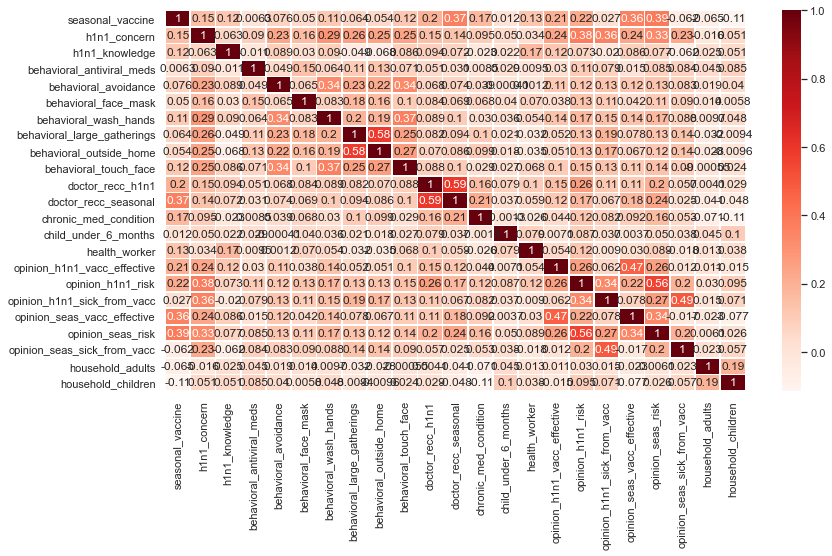

In [62]:
# creating dataset correlation heatmap
sns.heatmap(training_f_l.corr(), cmap='Reds', annot=True, linewidths=.7);

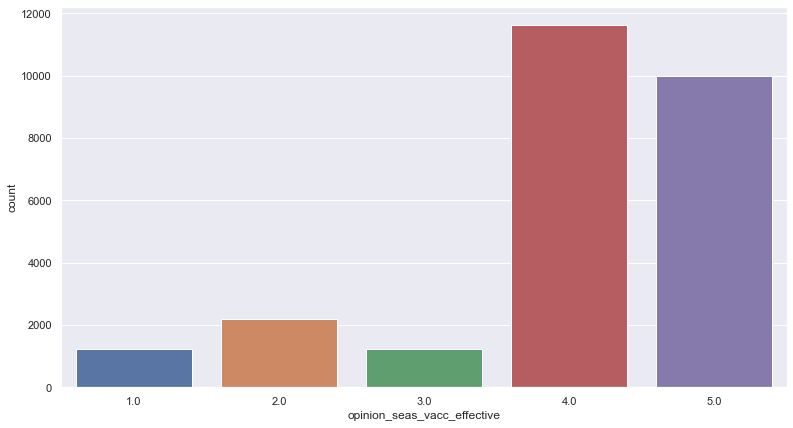

In [173]:
sns.countplot(x = 'opinion_seas_vacc_effective', data = training_f);

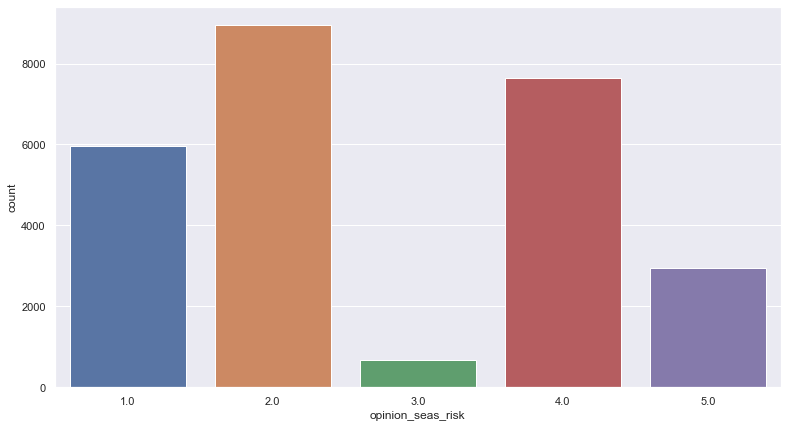

In [174]:
sns.countplot(x = 'opinion_seas_risk', data = training_f);

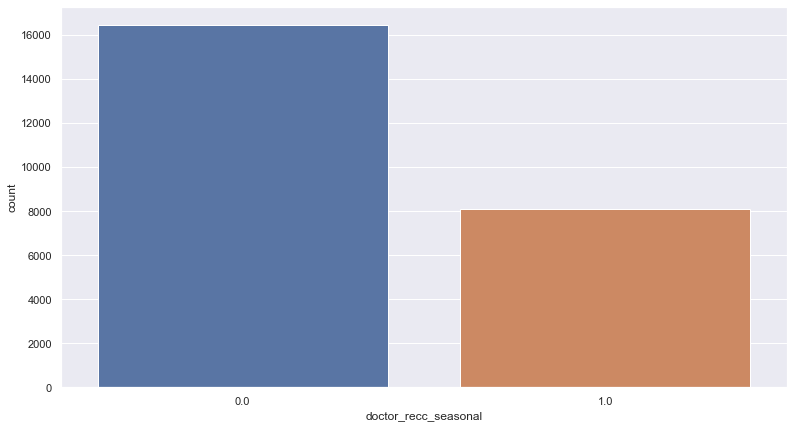

In [266]:
sns.countplot(x = 'doctor_recc_seasonal', data = training_f);

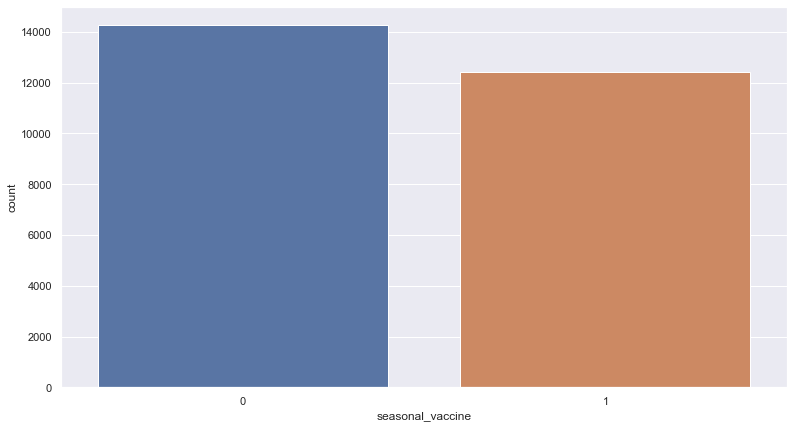

In [268]:
sns.countplot(x = 'seasonal_vaccine', data = training_l);

This will create a bar plot with doctor's recommendation on the x-axis, and the number of people with each vaccination status (0 or 1) represented by different colors. The legend will indicate which color corresponds to which vaccination status.

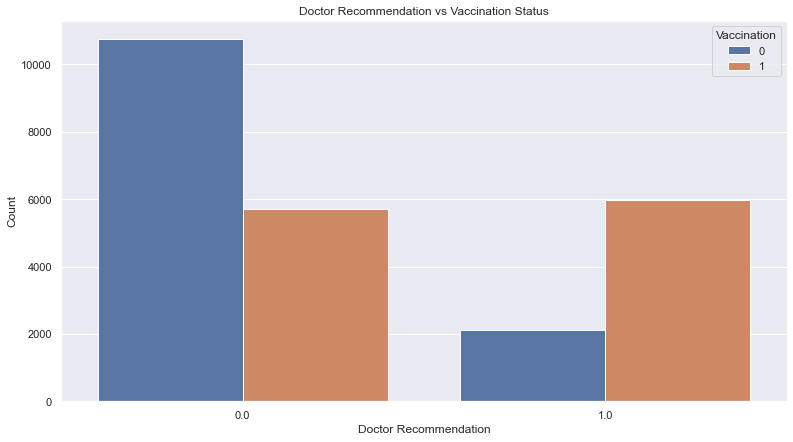

In [269]:
# Creating a count plot of doctor's recommendation vs vaccination status
sns.countplot(x='doctor_recc_seasonal', hue='seasonal_vaccine', data=training_f_l)

# Set the labels for the plot
plt.xlabel('Doctor Recommendation')
plt.ylabel('Count')
plt.title('Doctor Recommendation vs Vaccination Status')
plt.legend(title='Vaccination', loc='upper right')

# Show the plot
plt.show()

# To show the spread, let's make a convenient class that can help us organize the model and the cross-validation:

taken from lecture 11 topic 25

In [ ]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

## Preprocessing pipeline

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Making lists of numerical columns and object columns for preprocessing pipeline

In [117]:
training_f.dtypes != "object"

h1n1_concern                    True
h1n1_knowledge                  True
behavioral_antiviral_meds       True
behavioral_avoidance            True
behavioral_face_mask            True
behavioral_wash_hands           True
behavioral_large_gatherings     True
behavioral_outside_home         True
behavioral_touch_face           True
doctor_recc_h1n1                True
doctor_recc_seasonal            True
chronic_med_condition           True
child_under_6_months            True
health_worker                   True
opinion_h1n1_vacc_effective     True
opinion_h1n1_risk               True
opinion_h1n1_sick_from_vacc     True
opinion_seas_vacc_effective     True
opinion_seas_risk               True
opinion_seas_sick_from_vacc     True
age_group                      False
education                      False
race                           False
sex                            False
income_poverty                 False
marital_status                 False
rent_or_own                    False
e

In [118]:
numerical_features = training_f.columns[training_f.dtypes != 'object'].values
print(numeric)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [119]:
categorical_features = training_f.columns[training_f.dtypes == 'object'].values
print(categorical)

['age_group' 'education' 'race' 'sex' 'income_poverty' 'marital_status'
 'rent_or_own' 'employment_status' 'hhs_geo_region' 'census_msa']


### Finding the unique values for each feature

In [120]:
# Looping over each numeric feature and printing its unique values
for feature in numerical_features:
    print(feature)
    print(training_f[feature].unique())

h1n1_concern
[ 1.  3.  2.  0. nan]
h1n1_knowledge
[ 0.  2.  1. nan]
behavioral_antiviral_meds
[ 0.  1. nan]
behavioral_avoidance
[ 0.  1. nan]
behavioral_face_mask
[ 0.  1. nan]
behavioral_wash_hands
[ 0.  1. nan]
behavioral_large_gatherings
[ 0.  1. nan]
behavioral_outside_home
[ 1.  0. nan]
behavioral_touch_face
[ 1.  0. nan]
doctor_recc_h1n1
[ 0. nan  1.]
doctor_recc_seasonal
[ 0. nan  1.]
chronic_med_condition
[ 0.  1. nan]
child_under_6_months
[ 0.  1. nan]
health_worker
[ 0.  1. nan]
opinion_h1n1_vacc_effective
[ 3.  5.  4.  2.  1. nan]
opinion_h1n1_risk
[ 1.  4.  3.  2.  5. nan]
opinion_h1n1_sick_from_vacc
[ 2.  4.  1.  5.  3. nan]
opinion_seas_vacc_effective
[ 2.  4.  5.  3.  1. nan]
opinion_seas_risk
[ 1.  2.  4.  3.  5. nan]
opinion_seas_sick_from_vacc
[ 2.  4.  1.  5. nan  3.]
household_adults
[ 0.  2.  1.  3. nan]
household_children
[ 0.  3.  2.  1. nan]


In [121]:
# Looping over each object feature and printing its unique values
for feature in categorical_features:
    print(feature)
    print(training_f[feature].unique())

age_group
['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Years']
education
['< 12 Years' '12 Years' 'College Graduate' 'Some College' nan]
race
['White' 'Black' 'Other or Multiple' 'Hispanic']
sex
['Female' 'Male']
income_poverty
['Below Poverty' '<= $75,000, Above Poverty' '> $75,000' nan]
marital_status
['Not Married' 'Married' nan]
rent_or_own
['Own' 'Rent' nan]
employment_status
['Not in Labor Force' 'Employed' 'Unemployed' nan]
hhs_geo_region
['oxchjgsf' 'bhuqouqj' 'qufhixun' 'lrircsnp' 'atmpeygn' 'lzgpxyit'
 'fpwskwrf' 'mlyzmhmf' 'dqpwygqj' 'kbazzjca']
census_msa
['Non-MSA' 'MSA, Not Principle  City' 'MSA, Principle City']


/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


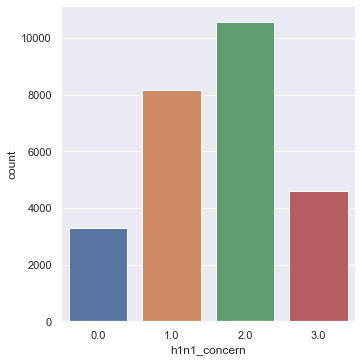

In [69]:
sns.factorplot('h1n1_concern', data = training_f, kind = "count")

### Setting up the Preprocessing Pipeline

The numerical pipeline first imputes missing values with the median and then scales the features. The categorical pipeline imputes missing values with the string 'missing' and then performs one-hot encoding on the features, and then the label-encoding.
We then combine the two pipelines using ColumnTransformer, which applies each pipeline to the appropriate features in the dataset.

In [158]:
# Defining the imputer to fill missing numerical values with the median
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

# Defining the imputer to fill missing categorical values with 'no category'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='no category')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining the numerical and categorical transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

## Not using the pipeline and doing manually

In [136]:
# For float fill missing values with the mean

for col in numerical_features:
    training_f[col] = training_f[col].fillna(training_f.mean())

# For string fill missing value with 'No Category'

for col in categorical_features:
    training_f[col] = training_f[col].fillna(value='no category')

In [147]:
# create a new dataframe called clean_training_f
clean_training_f = pd.DataFrame()

# fill missing values for numerical features
for col in numerical_features:
    clean_training_f[col] = training_f[col].fillna(training_f[col].median())

# fill missing values for categorical features
for col in categorical_features:
    clean_training_f[col] = training_f[col].fillna(value='no category')

In [148]:
clean_training_f

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City"
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City"
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,55 - 64 Years,Some College,White,Female,no category,Not Married,Own,no category,lzgpxyit,"MSA, Not Principle City"


In [149]:
clean_training_f.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_re

In [150]:
# Looping over each numeric feature and printing its unique values
for feature in numerical_features:
    print(feature)
    print(clean_training_f[feature].unique())

h1n1_concern
[1. 3. 2. 0.]
h1n1_knowledge
[0. 2. 1.]
behavioral_antiviral_meds
[0. 1.]
behavioral_avoidance
[0. 1.]
behavioral_face_mask
[0. 1.]
behavioral_wash_hands
[0. 1.]
behavioral_large_gatherings
[0. 1.]
behavioral_outside_home
[1. 0.]
behavioral_touch_face
[1. 0.]
doctor_recc_h1n1
[0. 1.]
doctor_recc_seasonal
[0. 1.]
chronic_med_condition
[0. 1.]
child_under_6_months
[0. 1.]
health_worker
[0. 1.]
opinion_h1n1_vacc_effective
[3. 5. 4. 2. 1.]
opinion_h1n1_risk
[1. 4. 3. 2. 5.]
opinion_h1n1_sick_from_vacc
[2. 4. 1. 5. 3.]
opinion_seas_vacc_effective
[2. 4. 5. 3. 1.]
opinion_seas_risk
[1. 2. 4. 3. 5.]
opinion_seas_sick_from_vacc
[2. 4. 1. 5. 3.]
household_adults
[0. 2. 1. 3.]
household_children
[0. 3. 2. 1.]


In [151]:
# Looping over each object feature and printing its unique values
for feature in categorical_features:
    print(feature)
    print(clean_training_f[feature].unique())

age_group
['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Years']
education
['< 12 Years' '12 Years' 'College Graduate' 'Some College' 'no category']
race
['White' 'Black' 'Other or Multiple' 'Hispanic']
sex
['Female' 'Male']
income_poverty
['Below Poverty' '<= $75,000, Above Poverty' '> $75,000' 'no category']
marital_status
['Not Married' 'Married' 'no category']
rent_or_own
['Own' 'Rent' 'no category']
employment_status
['Not in Labor Force' 'Employed' 'Unemployed' 'no category']
hhs_geo_region
['oxchjgsf' 'bhuqouqj' 'qufhixun' 'lrircsnp' 'atmpeygn' 'lzgpxyit'
 'fpwskwrf' 'mlyzmhmf' 'dqpwygqj' 'kbazzjca']
census_msa
['Non-MSA' 'MSA, Not Principle  City' 'MSA, Principle City']


In [233]:
# Apply Encoder to all categorical features
for feature in categorical_features:
    enc = OneHotEncoder()
    clean_training_f[feature] = enc.fit_transform(clean_training_f[feature])

ValueError: Expected 2D array, got 1D array instead:
array=[3 1 0 ... 3 0 4].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [234]:
display(clean_training_f.head())
display(clean_training_f.info())

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,3,1,3,0,2,1,0,1,8,2
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1,0,3,1,2,1,1,0,1,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,2,3,1,0,1,0,0,9,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,4,0,3,0,2,1,1,1,5,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,2,3,3,0,0,0,0,0,9,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26707 non-null  float64
 1   h1n1_knowledge               26707 non-null  float64
 2   behavioral_antiviral_meds    26707 non-null  float64
 3   behavioral_avoidance         26707 non-null  float64
 4   behavioral_face_mask         26707 non-null  float64
 5   behavioral_wash_hands        26707 non-null  float64
 6   behavioral_large_gatherings  26707 non-null  float64
 7   behavioral_outside_home      26707 non-null  float64
 8   behavioral_touch_face        26707 non-null  float64
 9   doctor_recc_h1n1             26707 non-null  float64
 10  doctor_recc_seasonal         26707 non-null  float64
 11  chronic_med_condition        26707 non-null  float64
 12  child_under_6_months         26707 non-null  float64
 13  health_worker   

None

We can now fit and transform our data using the pipeline.

In [123]:
X = training_f
y = training_l

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [125]:
X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
5303,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,White,Male,"> $75,000",Married,Own,Not in Labor Force,atmpeygn,"MSA, Principle City",1.0,0.0
2703,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Hispanic,Male,Below Poverty,Not Married,Rent,Employed,oxchjgsf,"MSA, Principle City",1.0,0.0
6586,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,White,Female,"> $75,000",Not Married,Rent,Employed,fpwskwrf,"MSA, Not Principle City",2.0,0.0
22563,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,White,Male,"> $75,000",Married,Own,Employed,atmpeygn,"MSA, Principle City",1.0,2.0
2338,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,kbazzjca,"MSA, Not Principle City",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,White,Male,"> $75,000",Not Married,Own,Not in Labor Force,qufhixun,"MSA, Principle City",0.0,0.0
5390,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Unemployed,mlyzmhmf,"MSA, Principle City",0.0,0.0
860,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,Non-MSA,1.0,0.0


In [159]:
# Fit and transform the data using the preprocessing pipeline
X_train_pp = preprocessor.fit_transform(X_train)
X_test_pp = preprocessor.transform(X_test)

ValueError: 'fill_value'=no category is invalid. Expected a numerical value when imputing numerical data

In [127]:
X_train_pp

array([[ 0.41710718,  1.19404056, -0.22696017, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.41710718, -0.4298895 , -0.22696017, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.52074398, -0.4298895 , -0.22696017, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.41710718, -0.4298895 , -0.22696017, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.41710718, -0.4298895 , -0.22696017, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.52074398, -0.4298895 , -0.22696017, ...,  1.        ,
         0.        ,  0.        ]])

In [167]:
X_train_pp = pd.DataFrame(X_train_pp)
X_train_pp.columns = col_name
display(X_train_pp)

ValueError: Length mismatch: Expected axis has 65 elements, new values have 32 elements

# Train test split

In [327]:
len(clean_training_f) == len(training_l)

True

In [328]:
X_train, X_test, y_train, y_test = train_test_split(clean_training_f, training_l, test_size=0.3, random_state=42)

### Normalization (making all values between 0-1)

In [329]:
# Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Modeling process

In [330]:
# many of the models need the y to be a 1d array and so I will use ravel() to make the y_train and y_test into arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Dummy Model

In [336]:
pd.DataFrame(y_train).value_counts(normalize=True)

0    0.531186
1    0.468814
dtype: float64

In [339]:
# dummy model that always chooses the majority class
dummy_model = DummyClassifier(strategy="most_frequent")

# fitting the model on training data
dummy_model.fit(X_train_sc, y_train)

# predicting
y_pred_dummy = dummy_model.predict(X_train_sc)

dummy_acc = accuracy_score(y_train, y_pred_dummy)
print()
print(f"The base Logistic Regression accuracy is: {dummy_acc*100 :.2f}%.")


The base Logistic Regression accuracy is: 53.12%.


### Dummy Model Evaluation

In [340]:
# Cross-validation
dummy_results = cross_val_score(dummy_model, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
dummy_mean_precision = dummy_results.mean()

# Printing the result
print(f"The mean precision of the model is: {dummy_mean_precision:.2f}")

The mean precision of the model is: 0.00


/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [341]:
# Cross validation for calassification gives us accuracy by default
cv_results = cross_validate(dummy_model, X_train_sc, y_train, cv=5)
display(cv_results)
print(f"The mean accuracy of the dummy model is {cv_results['test_score'].mean()} .")

{'fit_time': array([0.00264502, 0.00284791, 0.00207305, 0.00199699, 0.00177717]),
 'score_time': array([0.00060582, 0.00054097, 0.0010581 , 0.00052404, 0.00053978]),
 'test_score': array([0.53115806, 0.53115806, 0.53115806, 0.53115806, 0.53130016])}

The mean accuracy of the dummy model is 0.5311864830254354 .


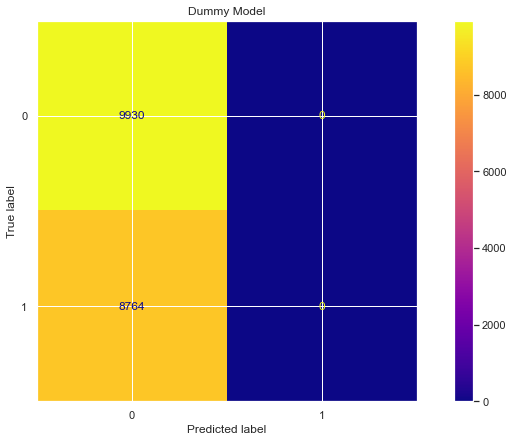

In [214]:
fig, ax = plt.subplots()

plt.title("Dummy Model")

plot_confusion_matrix(dummy_model, X_train_sc, y_train, ax=ax, cmap="plasma");

In [199]:
# just the numbers
confusion_matrix(y_train, dummy_model.predict(X_train_sc))

array([[9930,    0],
       [8764,    0]])

This is a pretty lopsided confusion matrix.

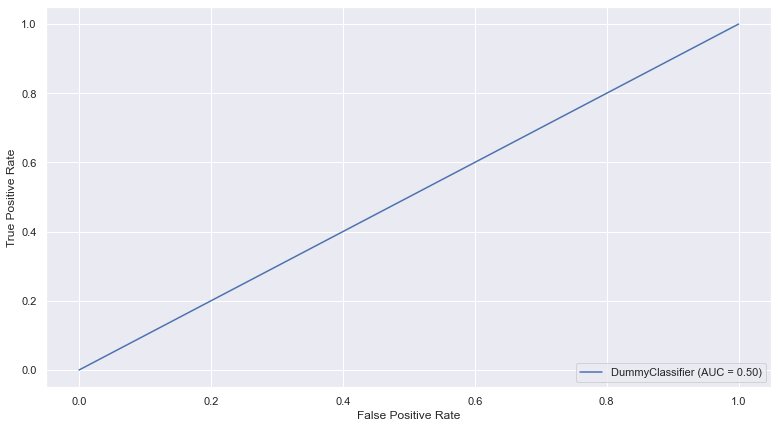

In [200]:
plot_roc_curve(dummy_model, X_train_sc, y_train);

The ROC value is very low, .5.

## Baseline Logistic Regression Model

In [277]:
# Initializing
lr_base = LogisticRegression()

# Training
lr_base.fit(X_train_sc, y_train)

# Predicting
y_pred_lr_base = lr_base.predict(X_train_sc)


print(classification_report(y_train, y_pred_lr_base))
print(confusion_matrix(y_train, y_pred_lr_base))

# Getting accuracy and precision scores of train set
lr_base_acc = accuracy_score(y_train, y_pred_lr_base)
lr_base_prec = precision_score(y_train, y_pred_lr_base)
print()
print(f"The base Logistic Regression accuracy is: {lr_base_acc*100 :.2f}%.")
print(f"The base Logistic Regression precission is: {lr_base_prec*100 :.2f}%.")

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      9930
           1       0.77      0.73      0.75      8764

    accuracy                           0.77     18694
   macro avg       0.77      0.77      0.77     18694
weighted avg       0.77      0.77      0.77     18694

[[8001 1929]
 [2368 6396]]

The base Logistic Regression accuracy is: 77.01%.
The base Logistic Regression precission is: 76.83%.


In [289]:
# Cross validation for calassification ives us accuracy by default
cv_lr_base = cross_validate(lr_base, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
lr_base_mean_acc = cv_lr_base['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the base logistic regression model is {lr_base_mean_acc:.4f}.")

The mean cross validation accuracy of the base logistic regression model is 0.7686.


In [297]:
# Cross-validation
lr_base_cv_results = cross_val_score(lr_base, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
lr_base_mean_precision = lr_base_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the logistic regression model is: {lr_base_mean_precision:.4f}")

The mean cross validation precision of the logistic regression model is: 0.7671


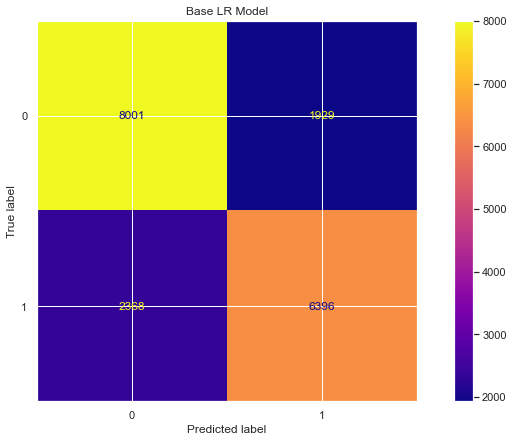

In [291]:
fig, ax = plt.subplots()

plt.title("Base LR Model")

plot_confusion_matrix(lr_base, X_train_sc, y_train, ax=ax, cmap="plasma");

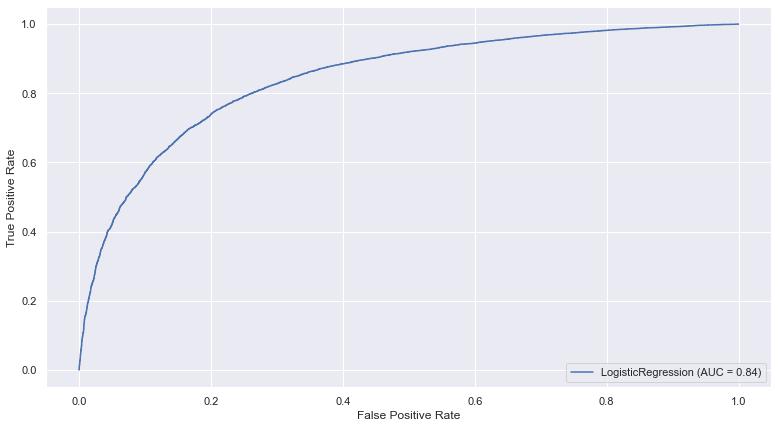

In [292]:
plot_roc_curve(lr_base, X_train_sc, y_train);

Much better looking confusion matrix as well as AUC compared to the dummy model.

## Baseline Decision Tree Model

Decision trees are a type of parametric model that recursively partitions the feature space into smaller and smaller regions based on the most informative features. The partitioning process stops when a stopping criterion is met, such as when all data points in a region belong to the same class or when a maximum depth is reached. Decision trees can work well when the decision boundary is nonlinear and can handle both continuous and categorical data. They are often used as standalone models or as part of an ensemble model, such as a random forest.

In [293]:
# Initializing
dt_base = DecisionTreeClassifier()

# Training
dt_base.fit(X_train_sc, y_train)

# Predicting
y_pred_dt_base = dt_base.predict(X_train_sc)


print(classification_report(y_train, y_pred_dt_base))
print(confusion_matrix(y_train, y_pred_dt_base))

# Getting accuracy and precision scores of train set
dt_base_acc = accuracy_score(y_train, y_pred_dt_base)
dt_base_prec = precision_score(y_train, y_pred_dt_base)
print()
print(f"The base Decision Tree Model accuracy is: {dt_base_acc*100 :.2f}%.")
print(f"The base Decision Tree Model precission is: {dt_base_prec*100 :.2f}%.")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9930
           1       1.00      1.00      1.00      8764

    accuracy                           1.00     18694
   macro avg       1.00      1.00      1.00     18694
weighted avg       1.00      1.00      1.00     18694

[[9930    0]
 [   0 8764]]

The base Decision Tree Model accuracy is: 100.00%.
The base Decision Tree Model precission is: 100.00%.


In [295]:
%%time
# Cross validation for calassification ives us accuracy by default
cv_dt_base = cross_validate(dt_base, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
dt_base_mean_acc = cv_dt_base['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the base decision tree model is {dt_base_mean_acc:.4f}.")

The mean cross validation accuracy of the base decision tree model is 0.6749.
CPU times: user 506 ms, sys: 9.32 ms, total: 515 ms
Wall time: 536 ms


In [296]:
# Cross-validation
dt_base_cv_results = cross_val_score(dt_base, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
dt_base_mean_precision = dt_base_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the decision tree model is: {dt_base_mean_precision:.4f}")

The mean cross validation precision of the decision tree model is: 0.6540


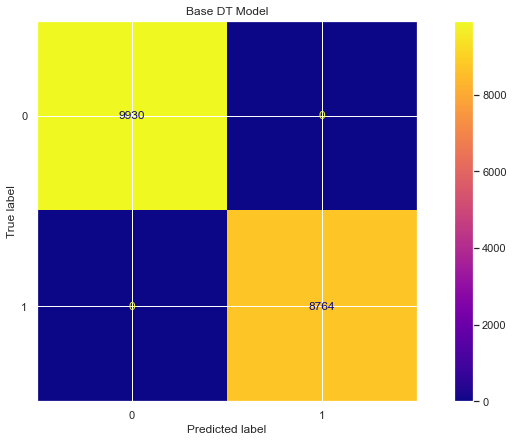

In [298]:
fig, ax = plt.subplots()

plt.title("Base DT Model")

plot_confusion_matrix(dt_base, X_train_sc, y_train, ax=ax, cmap="plasma");

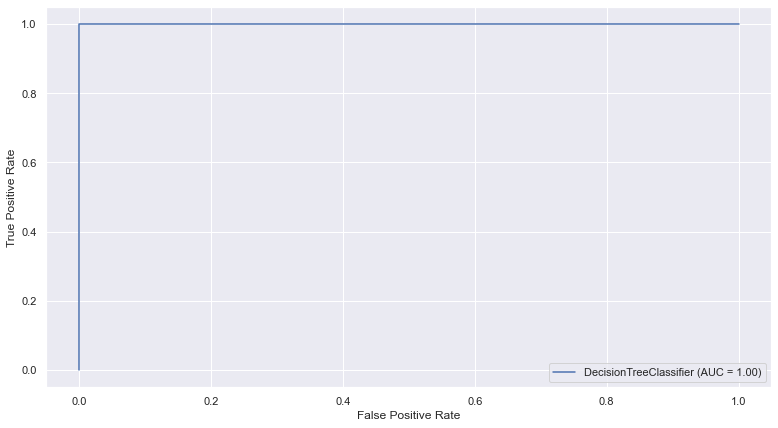

In [299]:
plot_roc_curve(dt_base, X_train_sc, y_train);

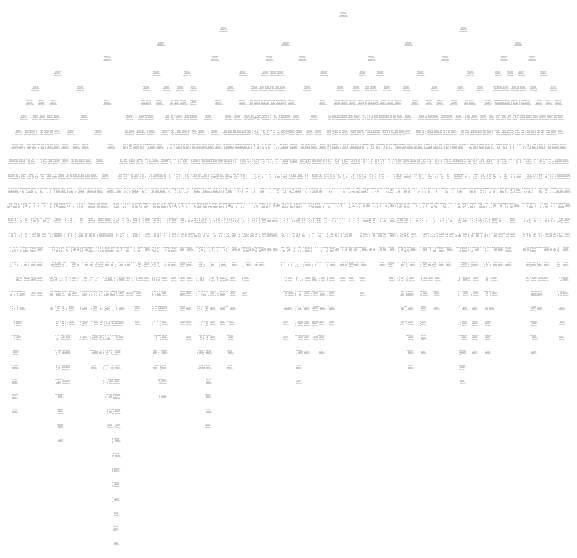

In [228]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(dt_base, ax=ax);

## Base KNN Model

KNN is a non-parametric and lazy learning algorithm, meaning that it does not make any assumptions about the underlying data distribution and it does not build a model during training. Instead, KNN stores all the training data in memory and predicts the label of a new data point based on the labels of its k nearest neighbors in the training data. The number of neighbors, k, is a hyperparameter that needs to be chosen based on the problem at hand. KNN can work well when the decision boundary is nonlinear

In [300]:
# Initializing
knn_base = KNeighborsClassifier()

# Training
knn_base.fit(X_train_sc, y_train)

# Predicting
y_pred_knn_base = knn_base.predict(X_train_sc)


print(classification_report(y_train, y_pred_knn_base))
print(confusion_matrix(y_train, y_pred_knn_base))

# Getting accuracy and precision scores of train set
knn_base_acc = accuracy_score(y_train, y_pred_knn_base)
knn_base_prec = precision_score(y_train, y_pred_knn_base)
print()
print(f"The base K nearest neighbors model accuracy is: {knn_base_acc*100 :.2f}%.")
print(f"The base K nearest neighbors model precission is: {knn_base_prec*100 :.2f}%.")

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      9930
           1       0.80      0.78      0.79      8764

    accuracy                           0.81     18694
   macro avg       0.80      0.80      0.80     18694
weighted avg       0.81      0.81      0.81     18694

[[8189 1741]
 [1897 6867]]

The base K nearest neighbors model accuracy is: 80.54%.
The base K nearest neighbors model precission is: 79.77%.


In [301]:
# Cross validation for calassification ives us accuracy by default
cv_knn_base = cross_validate(knn_base, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
knn_base_mean_acc = cv_knn_base['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the base K nearest neighbors model is {knn_base_mean_acc:.4f}.")

The mean cross validation accuracy of the base K nearest neighbors model is 0.7087.


In [302]:
# Cross-validation
knn_base_cv_results = cross_val_score(knn_base, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
knn_base_mean_precision = knn_base_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the base K nearest neighbors model is: {knn_base_mean_precision:.4f}")

The mean cross validation precision of the base K nearest neighbors model is: 0.6917


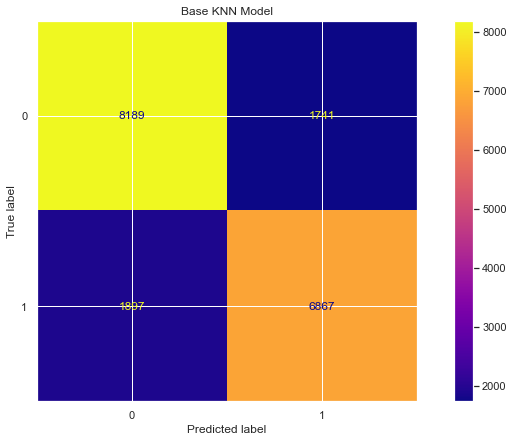

In [303]:
fig, ax = plt.subplots()

plt.title("Base KNN Model")

plot_confusion_matrix(knn_base, X_train_sc, y_train, ax=ax, cmap="plasma");

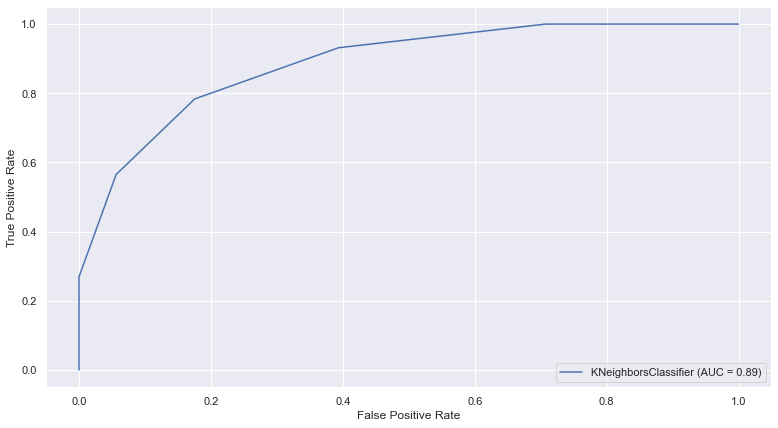

In [243]:
plot_roc_curve(knn_base, X_train_sc, y_train);

## Base Naive Bayes Model

In [304]:
# Initializing
gnb_base = GaussianNB()

# Training
gnb_base.fit(X_train_sc, y_train)

# Predicting
y_pred_gnb_base = gnb_base.predict(X_train_sc)


print(classification_report(y_train, y_pred_gnb_base))
print(confusion_matrix(y_train, y_pred_gnb_base))

# Getting accuracy and precision scores of train set
gnb_base_acc = accuracy_score(y_train, y_pred_gnb_base)
gnb_base_prec = precision_score(y_train, y_pred_gnb_base)
print()
print(f"The base naive bayes model accuracy is: {gnb_base_acc*100 :.2f}%.")
print(f"The base naive bayes model precission is: {gnb_base_prec*100 :.2f}%.")

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      9930
           1       0.71      0.72      0.71      8764

    accuracy                           0.73     18694
   macro avg       0.73      0.73      0.73     18694
weighted avg       0.73      0.73      0.73     18694

[[7336 2594]
 [2492 6272]]

The base naive bayes model accuracy is: 72.79%.
The base naive bayes model precission is: 70.74%.


In [305]:
# Cross validation for calassification ives us accuracy by default
cv_gnb_base = cross_validate(gnb_base, X_train_sc, y_train, cv=5)

# Getting the mean accuracy score
gnb_base_mean_acc = cv_gnb_base['test_score'].mean()

# Printing the result
print(f"The mean cross validation accuracy of the base naive bayes model is {gnb_base_mean_acc:.4f}.")

The mean cross validation accuracy of the base naive bayes model is 0.7284.


In [306]:
# Cross-validation
gnb_base_cv_results = cross_val_score(gnb_base, X_train_sc, y_train, cv=5, scoring='precision')

# Getting the mean precision score
gnb_base_mean_precision = gnb_base_cv_results.mean()

# Printing the result
print(f"The mean cross validation precision of the base naive bayes model is: {gnb_base_mean_precision:.4f}")

The mean cross validation precision of the base naive bayes model is: 0.7083


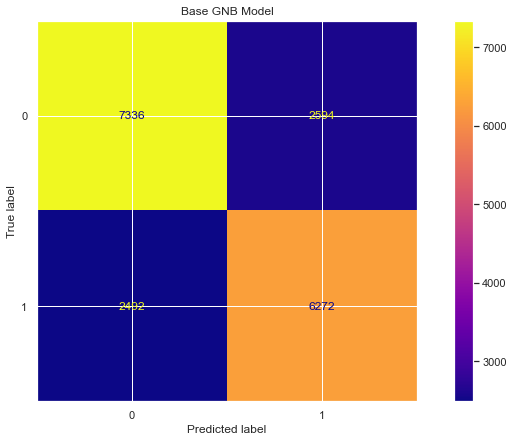

In [257]:
fig, ax = plt.subplots()

plt.title("Base GNB Model")

plot_confusion_matrix(gnb_base, X_train_sc, y_train, ax=ax, cmap="plasma");

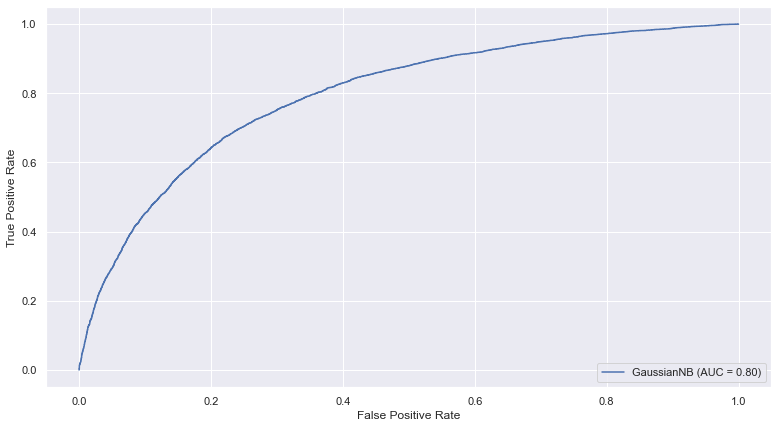

In [258]:
plot_roc_curve(gnb_base, X_train_sc, y_train);

# Model comparison

In [309]:
accuracy_score = [dummy_acc, lr_base_mean_acc, dt_base_mean_acc, knn_base_mean_acc, gnb_base_mean_acc]
mean_precision_score = [dummy_mean_precision, lr_base_mean_precision, dt_base_mean_precision,
                    knn_base_mean_precision, gnb_base_mean_precision]
Models = ['Dummy Model', 'Base Logistic Regression', 'Base Decission Tree', 
          'Base KNearest Neighbors', 'Base Gaussian NB']

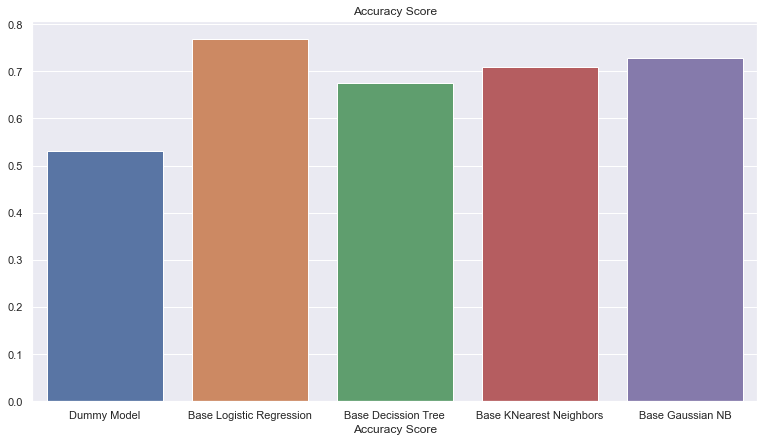

In [310]:
sns.barplot(x=Models, y=accuracy_score)
plt.xlabel('Accuracy Score')
plt.title('Accuracy Score')
plt.show()

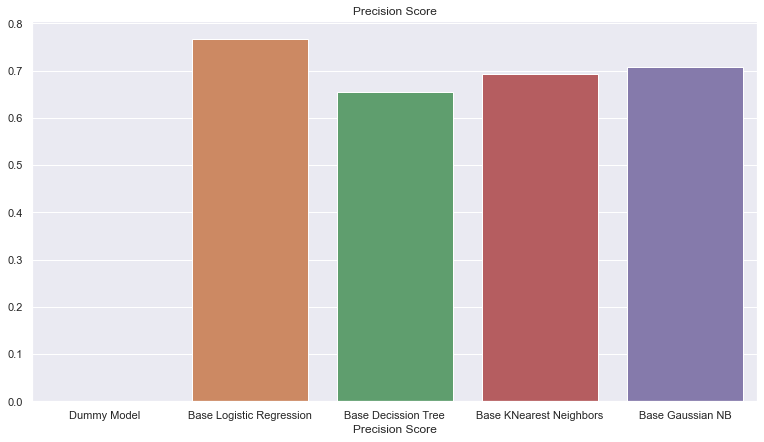

In [311]:
sns.barplot(x=Models, y=mean_precision_score)
plt.xlabel('Precision Score')
plt.title('Precision Score')
plt.show()

Since both the accuracy and precision score for the cross validation for the base logistic regression model were the highest, I will choose this model to iterate over for my final model.

# Hyperperameters

In [353]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

We are searching over different values of the regularization parameter C and the penalty type (l1 and l2) using logistic regression. We are using precision as the scoring metric for grid search since we want to decrease the amount of false positives.

In [362]:
%%time

# logistic regression regressor
lr_1 = LogisticRegression()

# defining the hyperparameters to search over
# defalut for penalty is 12 and C is 1
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': [0.01, 0.1, 1, 10, 100]}

# define the grid search object
grid_lr_1 = GridSearchCV(lr_1, param_grid, scoring='precision', cv=5)

# fit the grid search object to the training data
grid_lr_1.fit(X_train_sc, y_train)

/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings

CPU times: user 2.56 s, sys: 256 ms, total: 2.82 s
Wall time: 1.57 s


/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='precision')

The best_params_ attribute of the grid search object will give you the hyperparameters that resulted in the best precision score, and the best_score_ attribute will give you the precision score itself.

In [388]:
# get the best parameters and score
print(f"Best parameters: {grid_lr_1.best_params_}")
print()
print(f"Base lr model precision score: {lr_base_mean_precision}")
print(f"Best precision score for lr_1: {grid_lr_1.best_score_}")

Best parameters: {'C': 0.01, 'penalty': 'l2'}

Base lr model precision score: 0.7670639155314227
Best precision score for lr_1: 0.7727147670103798


It seems lit the precision score increase a little bit but not by much. Will search 

In [382]:
%%time

# best hyperparameters for logistic regression
best_params = grid_lr_1.best_params_

# creating a new logistic regression object with best hyperparameters from grid_lr_1
lr_2 = LogisticRegression(**best_params)

# define new parameters grid
param_grid_2 = {'class_weight': [None, 'balanced'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#              'tol': [1e-4, 1e-5, 1e-6], 
#              'max_iter': [100, 500, 1000, 10000]
               }

# define the grid search object
grid_lr_2 = GridSearchCV(estimator=lr_2, param_grid=param_grid_2, scoring='precision', cv=5)

CPU times: user 59 µs, sys: 1 µs, total: 60 µs
Wall time: 62.9 µs


In [383]:
%%time

# fit the grid search object to the training data with best hyperparameters fixed
grid_lr_2.fit(X_train_sc, y_train)

CPU times: user 7.76 s, sys: 638 ms, total: 8.4 s
Wall time: 4.42 s


GridSearchCV(cv=5, estimator=LogisticRegression(C=0.01),
             param_grid={'class_weight': [None, 'balanced'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='precision')

In [387]:
# get the best parameters and score
print(f"Best parameters: {grid_lr_2.best_params_}")
print()
print(f"Base lr model precision score: {lr_base_mean_precision}")
print(f"Best precision score for lr_1: {grid_lr_1.best_score_}")
print(f"Best precision score for lr_2: {grid_lr_2.best_score_}")

Best parameters: {'class_weight': None, 'solver': 'sag'}

Base lr model precision score: 0.7670639155314227
Best precision score for lr_1: 0.7727147670103798
Best precision score for lr_2: 0.7727429191674042


In [391]:
%%time

# best hyperparameters for logistic regression
best_params = {'C': 0.01, 'penalty': 'l2', 'class_weight': None, 'solver': 'sag'}

# creating a new logistic regression object with best hyperparameters from grid_lr_1
lr_3 = LogisticRegression(**best_params)

# define new parameters grid
param_grid_3 = {'tol': [1e-4, 1e-5, 1e-6], 
                'n_jobs': [-1, 1, 2, 4],
                'max_iter': [100, 500, 1000, 10000]
               }

# define the grid search object
grid_lr_3 = GridSearchCV(estimator=lr_3, param_grid=param_grid_3, scoring='precision', cv=5)

CPU times: user 75 µs, sys: 0 ns, total: 75 µs
Wall time: 79.2 µs


In [392]:
%%time

# fit the grid search object to the training data with best hyperparameters fixed
grid_lr_3.fit(X_train_sc, y_train)

CPU times: user 30.9 s, sys: 5.18 s, total: 36 s
Wall time: 1min 14s


GridSearchCV(cv=5, estimator=LogisticRegression(C=0.01, solver='sag'),
             param_grid={'max_iter': [100, 500, 1000, 10000],
                         'n_jobs': [-1, 1, 2, 4],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring='precision')

In [394]:
# get the best parameters and score
print(f"Best parameters: {grid_lr_3.best_params_}")
print()
print(f"Base lr model precision score: {lr_base_mean_precision}")
print(f"Best precision score for lr_1: {grid_lr_1.best_score_}")
print(f"Best precision score for lr_2: {grid_lr_2.best_score_}")
print(f"Best precision score for lr_3: {grid_lr_3.best_score_}")

Best parameters: {'max_iter': 100, 'n_jobs': -1, 'tol': 0.0001}

Base lr model precision score: 0.7670639155314227
Best precision score for lr_1: 0.7727147670103798
Best precision score for lr_2: 0.7727429191674042
Best precision score for lr_3: 0.7727429191674042
